# Topics – Easy Topic Modeling in Python

The text mining technique **Topic Modeling** has become a popular statistical method for clustering documents. This [Jupyter notebook](http://jupyter.org/) introduces a step-by-step workflow, basically containing data preprocessing, the actual topic modeling using **latent Dirichlet allocation** (LDA), which learns the relationships between words, topics, and documents, as well as some interactive visualizations to explore the model.

LDA, introduced in the context of text analysis in [2003](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), is an instance of a more general class of models called **mixed-membership models**. Involving a number of distributions and parameters, the topic model is typically performed using [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) with conjugate priors and is purely based on word frequencies.

There have been written numerous introductions to topic modeling for humanists (e.g. [this one](http://scottbot.net/topic-modeling-for-humanists-a-guided-tour/)), which provide another level of detail regarding its technical and epistemic properties.

For this workflow, you will need a corpus (a set of texts) as plain text (`.txt`) or [TEI XML](http://www.tei-c.org/index.xml) (`.xml`). Using the `dariah_topics` package, you also have the ability to process the output of [DARIAH-DKPro-Wrapper](https://github.com/DARIAH-DE/DARIAH-DKPro-Wrapper), a command-line tool for *natural language processing*.

Topic modeling works best with very large corpora. The [TextGrid Repository](https://textgridrep.org/) is a great place to start searching for text data. Anyway, to demonstrate the technique, we provide one small text collection in the folder `grenzboten_sample` containing 15 diary excerpts, as well as 15 war diary excerpts, which appeared in *Die Grenzboten*, a German newspaper of the late 19th and early 20th century.

**Of course, you can work with your own corpus in this notebook.**

We're relying on the LDA implementation by [Radim Řehůřek](https://radimrehurek.com/), called [Gensim](https://radimrehurek.com/project/gensim/), which is attractive because of its multi-core support. Aside from that, we provide two more Jupyter notebooks:

* [IntroducingMallet](IntroducingMallet.ipynb), using LDA by [MALLET](http://mallet.cs.umass.edu/topics.php), which is known to be very robust. 
* [IntroducingLda](IntroducingLda.ipynb), using LDA by [lda](http://pythonhosted.org/lda/index.html), which is lightweight.

For more information in general, have a look at the [documentation](http://dev.digital-humanities.de/ci/job/DARIAH-Topics/doclinks/1/).

## First step: Installing dependencies

To work within this Jupyter notebook, you will have to import the `dariah_topics` library. As you do, `dariah_topics` also imports a couple of external libraries, which have to be installed first. `pip` is the preferred installer program in Python. Starting with Python 3.4, it is included by default with the Python binary installers. If you are interested in `pip`, have a look at [this website](https://docs.python.org/3/installing/index.html).

To install the `dariah_topics` library with all dependencies, open your commandline, go with `cd` to the folder `Topics` and run:

```
pip install -r requirements.txt
```

Alternatively, you can do:

```
python setup.py install
```

If you get any errors or are not able to install *all* dependencies properly, try [Stack Overflow](https://stackoverflow.com/questions/tagged/pip) for troubleshooting or create a new issue on our [GitHub page](https://github.com/DARIAH-DE/Topics).

**Important**: If you are on macOS or Linux, you will have to use `pip3` and `python3`.

### Some final words
As you probably already know, code has to be written in the grey cells. You execute a cell by clicking the **Run**-button (or **Ctrl + Enter**). If you want to run all cells of the notebook at once, click **Cell > Run All** or **Kernel > Restart & Run All** respectively, if you want to restart the Python kernel first. On the left side of an (unexecuted) cell stands `In [ ]:`. The empty bracket means, that the cell hasn't been executed yet. By clicking **Run**, a star appears in the brackets (`In [*]:`), which means the process is running. In most cases, you won't see that star, because your computer is faster than your eyes. You can execute only one cell at once, all following executions will be in the waiting line. If the process of a cell is done, a number appears in the brackets (`In [1]:`).

## Starting with topic modeling!

Execute the following cell to import modules from the `dariah_topics` library.

In [1]:
from dariah_topics import preprocessing
from cophi_toolbox import preprocessing as pre
from dariah_topics import meta
from dariah_topics import postprocessing
from dariah_topics import visualization

C:\Program Files\WinPython-64bit-3.5.2.2\python-3.5.2.amd64\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using Theano backend.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Furthermore, we will need some additional functions from external libraries.

In [2]:
from bokeh.io import show
from gensim.models import LdaMulticore

Let's not pay heed to any warnings right now and execute the following cell.

In [3]:
import warnings
warnings.filterwarnings("ignore") 

The following line will just tell the notebook to show graphics in the output frames.

In [4]:
%matplotlib inline

## 1. Preprocessing
### 1.1. Reading a corpus of documents

#### Defining the path to the corpus folder

In the present example code, we are using the 30 diary excerpts from the folder `grenzboten`. To use your own corpus, change the path accordingly.

In [5]:
path_to_corpus = 'grenzboten_sample/*.txt'

By adding `/*.txt` to the actual path, we make sure to select only files with the suffix `.txt`.

#### Accessing file paths and metadata
We begin by creating a list of all the documents in the folder specified above. That list will tell the function `preprocessing.read_from_pathlist` (see below) which text documents to read. Furthermore, based on filenames we can create some metadata, e.g. author and title.

In [6]:
metadata = meta.fn2metadata(path_to_corpus)
metadata[:5] # by adding '[:5]' to the variable, only the first 5 elements will be printed

,author,basename,filename,title
0,Beck,Beck_1844_Tagebuch_56,grenzboten_sample\Beck_1844_Tagebuch_56.txt,1844_Tagebuch_56
1,Unbekannt,Unbekannt_1844_Tagebuch_70,grenzboten_sample\Unbekannt_1844_Tagebuch_70.txt,1844_Tagebuch_70
2,Nimmer,Nimmer_1844_Tagebuch_77,grenzboten_sample\Nimmer_1844_Tagebuch_77.txt,1844_Tagebuch_77
3,Unbekannt,Unbekannt_1844_Tagebuch_82,grenzboten_sample\Unbekannt_1844_Tagebuch_82.txt,1844_Tagebuch_82
4,Jörgel,Jörgel_1844_Tagebuch_88,grenzboten_sample\Jörgel_1844_Tagebuch_88.txt,1844_Tagebuch_88


#### Read listed documents from folder

In [7]:
corpus = list(pre.read_from_pathlist(metadata['filename']))
corpus[0][:255] # printing the first 255 characters of the first document

'Tagebuch von Karl Beck. Man spricht seit vierzehn Tagen von einem vollständigen Ministerwechsel und es circuliren im Publicum die verschiedensten Combinationen, wobei heute ganz andere Namen genannt werden, als gestern und morgen wieder andere, als heute.'

Your `corpus` contains as much elements (`documents`) as texts in your corpus are. Each element of `corpus` is a list containing exactly one element, the text itself as one single string including all whitespaces and punctuations:

```
[['This is the content of your first document.'],
 ['This is the content of your second document.'],
 ...
 ['This is the content of your last document.']]
```

### 1.3. Tokenize corpus
Now, your `documents` in `corpus` will be tokenized. Tokenization is the task of cutting a stream of characters into linguistic units, simply words or, more precisely, tokens. The tokenize function `dariah_topics` provides is a simple Unicode tokenizer. Depending on the corpus, it might be useful to use an external tokenizer function, or even develop your own, since its efficiency varies with language, epoch and text type.

In [8]:
tokenized_corpus = [list(pre.tokenize(document)) for document in corpus]

At this point, each `document` is represented by a list of separate token strings. As above, have a look at the first document (which has the index `0` as Python starts counting at 0) and show its first 14 words/tokens (that have the indices `0:13` accordingly).

In [9]:
tokenized_corpus[0][0:13]

['tagebuch',
 'von',
 'karl',
 'beck',
 'man',
 'spricht',
 'seit',
 'vierzehn',
 'tagen',
 'von',
 'einem',
 'vollständigen',
 'ministerwechsel']

### 1.4. Create a document-term matrix

The LDA topic model is based on a bag-of-words model of the corpus. To improve performance in large corpora, actual words and document titels are replaced by indices in the actual bag-of-words model.

**Because of Gensim's API, you will have to choose the large corpus model.**

In [10]:
document_term_matrix, document_ids, type_ids = pre.create_document_term_matrix(tokenized_corpus, metadata['title'], large_corpus=True)

### 1.5. Feature removal

*Stopwords* (also known as *most frequent tokens*) and *hapax legomena* are harmful for LDA and have to be removed from the corpus or the document-term matrix respectively. In this example, the 50 most frequent tokens will be categorized as stopwords.

**Hint**: Be careful with removing most frequent tokens, you might remove tokens quite important for LDA. Anyway, to gain better results, it is highly recommended to use an external stopwords list.

In this notebook, we combine the 50 most frequent tokens, hapax legomena and an external stopwordslist.

#### List the 100 most frequent words

In [11]:
stopwords = pre.find_stopwords(document_term_matrix, most_frequent_tokens=100, type_ids=type_ids)

These are the five most frequent words:

In [12]:
stopwords[:5]

['die', 'der', 'und', 'in', 'den']

#### List hapax legomena

In [13]:
hapax_legomena = pre.find_hapax_legomena(document_term_matrix, type_ids)
print("Total number of types in corpus:", len(type_ids))
print("Total number of hapax legomena:", len(hapax_legomena))

Total number of types in corpus: 24451
Total number of hapax legomena: 15823


#### Optional: Use external stopwordlist

In [14]:
path_to_stopwordlist = 'tutorial_supplementals/stopwords/de.txt'
external_stopwords = [line.strip() for line in open(path_to_stopwordlist, 'r', encoding='utf-8')]

#### Combine lists and remove content from `document_term_matrix`

In [16]:
features = stopwords + hapax_legomena + external_stopwords
document_term_matrix = pre.remove_features(features, document_term_matrix=document_term_matrix, type_ids=type_ids)

### 1.6. Creating specific Gensim corpus format

With the function below, you can create the specific Gensim corpus format.

In [22]:
gensim_corpus = postprocessing.doc2bow(document_term_matrix)

## 2. Model creation

The actual topic modeling is done with external state-of-the-art LDA implementations. In this example, we are relying on the open-source toolkit **Gensim** which was used and cited in over 400 commercial and academic applications since 2008.

### 2.1. Rearrange dictionaries 

In [23]:
doc2id = {value : key for key, value in document_ids.items()}
type2id = {value : key for key, value in type_ids.items()}

### 2.2. Generate LDA model

We use the class `LDA` from the library `lda` (which is basically not the same, because Python is case sensitive) to generate a LDA topic model. To instance a `LDA` object, there have to be specified a couple of parameters.

But first, if you are curious about any library, module, class or function, try `help()`. This can be very useful, because (at least in a well documented library) explanations of use and parameters will be printed. We're interested in the class `LDA` of the library `lda`, so let's try:

```
help(LdaMulticore)
```

This will print something like this (in fact even more):

```
Help on class LdaMulticore in module gensim.models.ldamulticore:

class LdaMulticore(gensim.models.ldamodel.LdaModel)
 |  The constructor estimates Latent Dirichlet Allocation model parameters based
 |  on a training corpus:
 |  
 |  >>> lda = LdaMulticore(corpus, num_topics=10)
 |  
 |  You can then infer topic distributions on new, unseen documents, with
 |  
 |  >>> doc_lda = lda[doc_bow]
 |  
 |  The model can be updated (trained) with new documents via
 |  
 |  >>> lda.update(other_corpus)
 |  
 |  Methods defined here:
 |  
 |  __init__(parameter ...)
 |      If given, start training from the iterable `corpus` straight away. If not given,
 |      the model is left untrained (presumably because you want to call `update()` manually).
 |      
 |      `num_topics` is the number of requested latent topics to be extracted from
 |      the training corpus.
 |      
 |      `id2word` is a mapping from word ids (integers) to words (strings). It is
 |      used to determine the vocabulary size, as well as for debugging and topic
 |      printing.
 |      
 |      `workers` is the number of extra processes to use for parallelization. Uses
 |      all available cores by default: `workers=cpu_count()-1`. **Note**: for
 |      hyper-threaded CPUs, `cpu_count()` returns a useless number -- set `workers`
 |      directly to the number of your **real** cores (not hyperthreads) minus one,
 |      for optimal performance.
 |      
 |      If `batch` is not set, perform online training by updating the model once
 |      every `workers * chunksize` documents (online training). Otherwise,
 |      run batch LDA, updating model only once at the end of each full corpus pass.
 |      
 |      `alpha` and `eta` are hyperparameters that affect sparsity of the document-topic
 |      (theta) and topic-word (lambda) distributions. Both default to a symmetric
 |      1.0/num_topics prior.
 |      
 |      `alpha` can be set to an explicit array = prior of your choice. It also
 |      support special values of 'asymmetric' and 'auto': the former uses a fixed
 |      normalized asymmetric 1.0/topicno prior, the latter learns an asymmetric
 |      prior directly from your data.
 |      
 |      `eta` can be a scalar for a symmetric prior over topic/word
 |      distributions, or a matrix of shape num_topics x num_words,
 |      which can be used to impose asymmetric priors over the word
 |      distribution on a per-topic basis. This may be useful if you
 |      want to seed certain topics with particular words by boosting
 |      the priors for those words.
```

So, now you know how to define the number of topics and the number of sampling iterations as well. A higher number of iterations will probably yield a better model, but also increases processing time. `alpha`, `eta` and `random_state` are so-called *hyperparameters*. They influence the model's performance, so feel free to play around with them. In the present example, we will leave the default values. Furthermore, there exist various methods for hyperparameter optimization, e.g. gridsearch or Gaussian optimization.

**Warning: This step can take quite a while!** Meaning something between some seconds and some hours depending on corpus size and the number of iterations. Our example corpus should be done within a minute or two at `iterations=5000`.

In [24]:
%%time

model = LdaMulticore(corpus=gensim_corpus, id2word=type2id, num_topics=10, passes=10, iterations=5000)

Wall time: 44.4 s


### 2.3. Create document-topic matrix

The generated model object can now be translated into a human-readable document-topic matrix (that is a actually a pandas data frame) that constitutes our principle exchange format for topic modeling results. For generating the matrix from a Gensim model, we can use the following function:

In [25]:
topics = postprocessing.show_topics(model=model)
topics

,Key 0,Key 1,Key 2,Key 3,Key 4,Key 5,Key 6,Key 7,Key 8,Key 9
Topic 0,märz,lassen,stadt,zeitung,weise,hiesigen,deutschland,berlin,nämlich,wien
Topic 1,leipzig,leipziger,zeitung,weiß,leben,weise,oesterreich,deutschland,stadt,bildung
Topic 2,dezember,türken,englische,österreicher,abgewiesen,geschütze,östlich,genommen,letzten,südlich
Topic 3,september,august,frankreich,rußland,kirche,kunst,england,paris,rom,deutschland
Topic 4,oesterreich,lassen,berlin,leben,preußen,deutschland,frankreich,könig,französischen,deutscher
Topic 5,frankreich,preußen,lamennais,französischen,krakauer,lassen,oesterreich,michelet,sprache,polen
Topic 6,dezember,juli,abgewiesen,august,englische,türken,südlich,zusammengebrochen,somme,genommen
Topic 7,abgewiesen,genommen,südlich,franzosen,geschütze,januar,nördlich,abgeschlagen,feindliche,englische
Topic 8,abgeschlagen,südlich,westlich,abgewiesen,verlusten,scheint,lassen,franzosen,französischen,italienische
Topic 9,presse,himmel,briefe,dame,meinung,regierung,geben,organe,zeitungen,rellstab


## 3. Model visualization

Each topic has a certain probability for each document in the corpus (have a look at the cell below). This probability distributions are visualized in an interactive **heatmap** (the darker the color, the higher the probability) which displays the kind of information
                that is presumably most useful to literary scholars. Going beyond pure exploration, this visualization can be used to show thematic developments over a set of texts as well as a single text, akin to a dynamic topic model. What might become
                apparent here, is that some topics correlate highly with a specific author or group of authors, while other topics correlate highly with a specific text or group of texts.

In [26]:
document_topics = postprocessing.show_document_topics(topics=topics,
                                                      model=model,
                                                      document_labels=metadata['title'],
                                                      doc2bow=gensim_corpus)
document_topics[:5]

title,1844_Tagebuch_56,1844_Tagebuch_70,1844_Tagebuch_77,1844_Tagebuch_82,1844_Tagebuch_88,1845_Tagebuch_52,1845_Tagebuch_62,1845_Tagebuch_81,1845_Tagebuch_85,1845_Tagebuch_93,...,1915_Kriegstagebuch_33,1915_Kriegstagebuch_39,1915_Kriegstagebuch_73,1915_Kriegstagebuch_94,1915_Kriegstagebuch_99,1916_Kriegstagebuch_41,1916_Kriegstagebuch_48,1916_Kriegstagebuch_49,1916_Kriegstagebuch_69,1916_Kriegstagebuch_81
märz lassen stadt,0.0,0.285186,0.99238,0.112876,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.899675,0.000000,0.000000,0.214793,0.000000,0.00000,0.0,0.375157,0.999568
leipzig leipziger zeitung,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.261548,0.0,0.0,...,0.145007,0.100078,0.000000,0.000000,0.000000,0.000000,0.99885,0.0,0.171470,0.000000
dezember türken englische,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000
september august frankreich,0.0,0.000000,0.00000,0.000000,0.585314,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.816123,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000
oesterreich lassen berlin,0.0,0.714591,0.00000,0.000000,0.411548,0.0,0.0,0.000000,0.0,0.0,...,0.854836,0.000000,0.000000,0.990952,0.000000,0.994163,0.00000,0.0,0.000000,0.000000


### 3.1. Distribution of topics

#### Distribution of topics over all documents

The distribution of topics over all documents can now be visualized in a heat map.

In [27]:
plot = visualization.doc_topic_heatmap_interactive(document_topics, title='Grenzboten')
show(plot, notebook_handle=True)

Loading BokehJS ...

Or a static heatmap:

<module 'matplotlib.pyplot' from 'C:\\Program Files\\WinPython-64bit-3.5.2.2\\python-3.5.2.amd64\\lib\\site-packages\\matplotlib\\pyplot.py'>

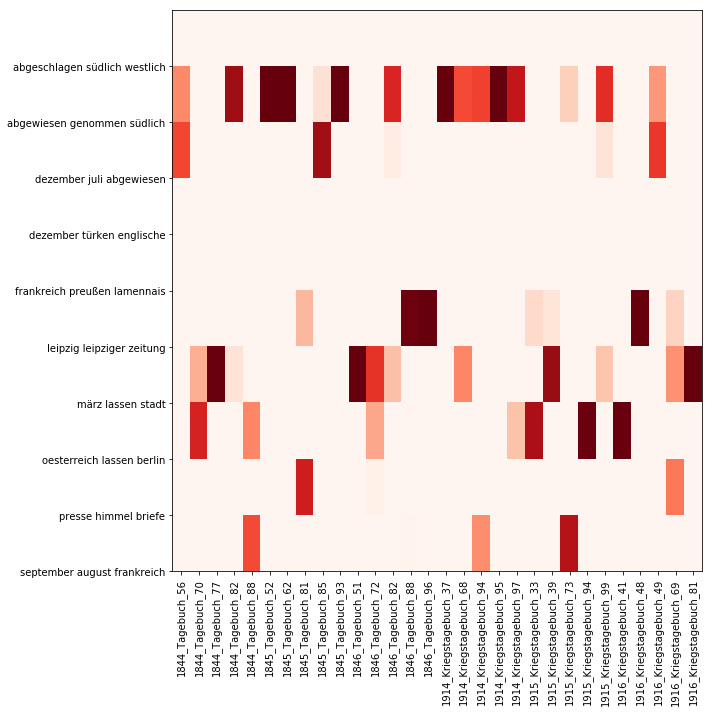

In [28]:
visualization.doc_topic_heatmap(document_topics)